In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
%matplotlib inline
import os

Display Function


In [2]:
def display_image(image,cmap=None):
    plt.imshow(image,cmap)
    plt.axis('off')

Reading Image

In [3]:
name="06.jpg"
filepath="images/"+name

In [4]:
sudoku_image=cv2.imread(filepath)

In [5]:
sudoku_image=cv2.cvtColor(sudoku_image,cv2.COLOR_BGR2RGB)

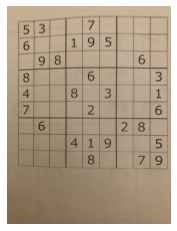

In [6]:
display_image(sudoku_image)

In [7]:
sudoku_gray=cv2.cvtColor(sudoku_image,cv2.COLOR_RGB2GRAY)

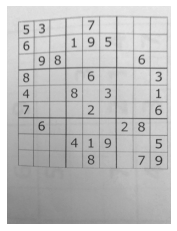

In [8]:
display_image(sudoku_gray,"gray")

Image Processing

In [9]:
image1=cv2.GaussianBlur(sudoku_gray,(9,9),0)

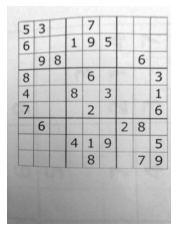

In [10]:
display_image(image1,"gray")

In [11]:
image2=cv2.adaptiveThreshold(image1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

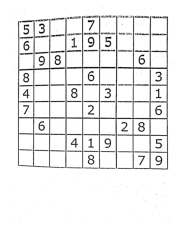

In [12]:
display_image(image2,"gray")

In [13]:
image3=cv2.bitwise_not(image2)

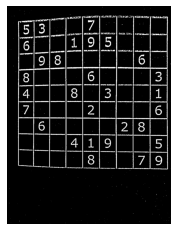

In [14]:
display_image(image3,"gray")

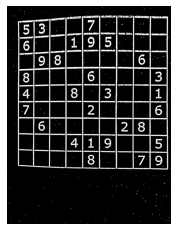

In [15]:
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
image4 = cv2.dilate(image3, kernel)
display_image(image4,"gray")

In [16]:
contours,hierchy=cv2.findContours(image4,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [17]:
contours=sorted(contours,key=cv2.contourArea,reverse=True)

In [18]:
polygon=contours[0]

In [19]:
max=0
bottom_right=[0,0]
top_left=[0,0]
for pt in polygon:
    x=pt[0][0]
    y=pt[0][1]
    
    if x+y>max:
        max=x+y
        bottom_right=[x,y]

min=max
for pt in polygon:
    x=pt[0][0]
    y=pt[0][1]
    
    if x+y<min:
        min=x+y
        top_left=[x,y]

In [20]:
max=0
top_right=[0,0]
bottom_left=[0,0]
for pt in polygon:
    x=pt[0][0]
    y=pt[0][1]
    
    if x-y>max:
        max=x-y
        bottom_left=[x,y]
        
min=max
for pt in polygon:
    x=pt[0][0]
    y=pt[0][1]
    
    if x-y<min:
        min=x-y
        top_right=[x,y]

In [21]:
def distance(pt1,pt2):
    x1,y1=pt1
    x2,y2=pt2
    
    a=(x1-x2)**2
    b=(y1-y2)**2
    c=a+b
    d=np.sqrt(c)
    
    return int(d)

In [22]:
side=np.max([distance(top_left,top_right),distance(top_left,bottom_left),distance(bottom_left,bottom_right),distance(bottom_right,top_right)])

In [23]:
src = np.array([top_left,top_right, bottom_right, bottom_left], dtype='float32')

In [24]:
dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
m = cv2.getPerspectiveTransform(src, dst)
image5=cv2.warpPerspective(sudoku_gray, m, (int(side), int(side)))

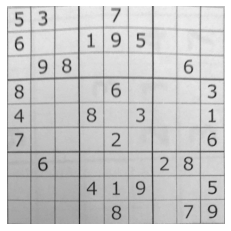

In [25]:
image6=cv2.flip(image5,0)
crop_image=cv2.rotate(image6,cv2.ROTATE_90_CLOCKWISE)
display_image(crop_image,"gray")

In [26]:
def image_saver(image):
    image_index=str(np.random.randint(0,10000000))+".jpeg"
    cv2.imwrite(image_index,image)
    
    return

In [27]:
def identify_number(image):
    my_model=load_model("my_model.h5")
    image= image[10:40,10:40]
    image =cv2.resize(image,(28,28))
    
    kernel = np.array([[0, 1., 0], [1., 1., 1.], [0, 1., 0]],np.uint8)
    
    
    if np.sum(image)==0:
        return 0
    
    image_saver(image)
    image=np.reshape(image,(1,28,28,1))
    k=my_model.predict_classes(image)
    return k[0]

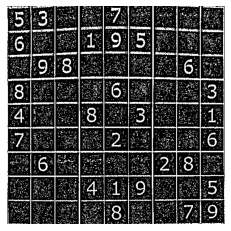

In [28]:
sudoku_image1=cv2.resize(crop_image,(450,450))

sudoku_image1=cv2.adaptiveThreshold(sudoku_image1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
sudoku_image1=cv2.bitwise_not(sudoku_image1)
display_image(sudoku_image1,"gray")

In [29]:
grid=np.zeros((9,9),dtype=int)
mean=0

for i in range(0,9):
    for j in range(0,9):
        image=sudoku_image1[i*50:(i+1)*50,j*50:(j+1)*50]
        mean=mean+image.sum()
        
mean=mean/81        
for i in range(0,9):
    for j in range(0,9):
        image=sudoku_image1[i*50:(i+1)*50,j*50:(j+1)*50]
        grid[i][j]=identify_number(image)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [30]:
grid

array([[5, 3, 2, 8, 1, 2, 3, 8, 3],
       [5, 3, 8, 1, 7, 0, 3, 3, 4],
       [5, 3, 8, 3, 2, 3, 3, 5, 7],
       [8, 3, 3, 3, 0, 3, 3, 2, 3],
       [4, 7, 3, 8, 3, 3, 3, 5, 1],
       [7, 3, 3, 3, 2, 5, 5, 3, 5],
       [3, 5, 5, 3, 3, 3, 2, 8, 3],
       [5, 3, 2, 4, 1, 9, 3, 3, 5],
       [3, 3, 3, 3, 8, 3, 7, 1, 3]])

In [31]:
def rowcheck(grid):
    a=list()
    for i in range(0,9):
        for j in range(0,9):
            if grid[i][j] in a:
                grid[i][j]=0
            if grid[i][j]!=0:
                a.append(grid[i][j])
        a.clear()
    return grid

In [32]:
def colcheck(grid):
    a=list()
    for i in range(0,9):
        for j in range(0,9):
            if grid[j][i] in a:
                grid[j][i]=0
            if grid[j][i]!=0:
                a.append(grid[j][i])
        a.clear()
    return grid

In [33]:
def boxcheck(grid):
    a=list()
    for i in range(0,3):
        for j in range(0,3):
            a=grid[3*i:3*(i+1),3*j:3*(j+1)]

In [34]:
grid=rowcheck(grid)
grid=colcheck(grid)

In [35]:
grid

array([[5, 3, 2, 8, 1, 0, 0, 0, 0],
       [0, 0, 8, 1, 7, 0, 0, 0, 4],
       [0, 0, 0, 0, 2, 0, 0, 0, 7],
       [8, 0, 0, 0, 0, 0, 0, 2, 0],
       [4, 7, 3, 0, 0, 0, 0, 5, 1],
       [7, 0, 0, 0, 0, 5, 0, 0, 0],
       [3, 5, 0, 0, 0, 0, 2, 8, 0],
       [0, 0, 0, 4, 0, 9, 0, 0, 0],
       [0, 0, 0, 0, 8, 0, 7, 1, 0]])

In [36]:
def findNextCellToFill(grid, i, j):
        for x in range(i,9):
                for y in range(j,9):
                        if grid[x][y] == 0:
                                return x,y
        for x in range(0,9):
                for y in range(0,9):
                        if grid[x][y] == 0:
                                return x,y
        return -1,-1

def isValid(grid, i, j, e):
        rowOk = all([e != grid[i][x] for x in range(9)])
        if rowOk:
                columnOk = all([e != grid[x][j] for x in range(9)])
                if columnOk:
                        
                        secTopX, secTopY = 3 *(i//3), 3 *(j//3)  
                        for x in range(secTopX, secTopX+3):
                                for y in range(secTopY, secTopY+3):
                                        if grid[x][y] == e:
                                                return False
                        return True
        return False

def solveSudoku(grid, i=0, j=0):
         
        i,j = findNextCellToFill(grid, i, j)
        if i == -1:
                return True
        for e in range(1,10):
                if isValid(grid,i,j,e):
                        grid[i][j] = e
                        if solveSudoku(grid, i, j):
                                return True
                        
                        grid[i][j] = 0
        return False
# put output numpy array equal to varible arr as done below
arr=grid
a=arr.tolist()
solveSudoku(a)

False

In [37]:
a

[[5, 3, 2, 8, 1, 0, 0, 0, 0],
 [0, 0, 8, 1, 7, 0, 0, 0, 4],
 [0, 0, 0, 0, 2, 0, 0, 0, 7],
 [8, 0, 0, 0, 0, 0, 0, 2, 0],
 [4, 7, 3, 0, 0, 0, 0, 5, 1],
 [7, 0, 0, 0, 0, 5, 0, 0, 0],
 [3, 5, 0, 0, 0, 0, 2, 8, 0],
 [0, 0, 0, 4, 0, 9, 0, 0, 0],
 [0, 0, 0, 0, 8, 0, 7, 1, 0]]